## 평가기준
| 평가기준  |상세기준 |
| --- | --- |
|1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.  | 데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다. |
|2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.  |적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.  |
|3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.  |3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.  |

In [11]:
## 라이브러리 버전 확인하기

In [12]:
import pandas 
import tensorflow
import datetime as dt
from pathlib import Path
import numpy as np
import warnings
import os
warnings.filterwarnings('ignore')

print(pandas.__version__)
print(tensorflow.__version__)
import pandas as pd

1.3.3
2.6.0


In [13]:
## 데이터 확인

In [14]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103


- sessionID 대신 UserID 항목이 들어가있다.
- rating 정보가 포함되어있다. 실습내역에서는 이런 항목이 포함되지 않았음, 하지만 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있다.

## data processing
- 날짜변환
- 기본 분석
- session length
- session time
- cleaning

In [15]:
# 날짜가 보기 어렵게 되어있어서 변환을 하였다
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data.head(10)

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
36,1,1836,5,2000-12-31 22:02:52
3,1,3408,4,2000-12-31 22:04:35
7,1,2804,5,2000-12-31 22:11:59
47,1,1207,4,2000-12-31 22:11:59
0,1,1193,5,2000-12-31 22:12:40


In [16]:
data['Time'].min(), data['Time'].max()

(Timestamp('2000-04-25 23:05:32'), Timestamp('2003-02-28 17:49:50'))

In [17]:
# 유저수, 아이템 수 
data['UserId'].nunique(), data['ItemId'].nunique()
# - 세션의 숫자는 60540, 아이텝의 숫자 3706개

(6040, 3706)

In [18]:
# session length - 브라우저에서 웹서버로 접속할 때 항상 포함한게 되는 유저 구분자
# - 로그인하지 안항ㅆ기 때무넹 사용자를 알 수없어도, 최소한 특성 사용자의 행동을 모아 분류한다. 그래서 session_length 란#
# - 세션의 사용자가 그 세션 동안 몇번의 액션을 취했는지 의미이다
session_length=data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [19]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [20]:
session_length.max(), session_length.min()

(2314, 20)

In [21]:
session_length.quantile(0.999)
# 99퍼센트 세션은 길이가 1343 개 이하이다, 평균이 165, 최대는 2314 임

1343.181000000005

In [22]:
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]


,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
...,...,...,...,...
697882,4169,3754,2,2002-06-15 20:52:27
695702,4169,1413,3,2002-06-15 21:03:51
697358,4169,494,4,2002-06-15 21:16:00
695945,4169,1804,2,2002-06-15 21:16:23


In [23]:
# 99퍼센트 까지 분포 누적합을 시각화 해보자
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

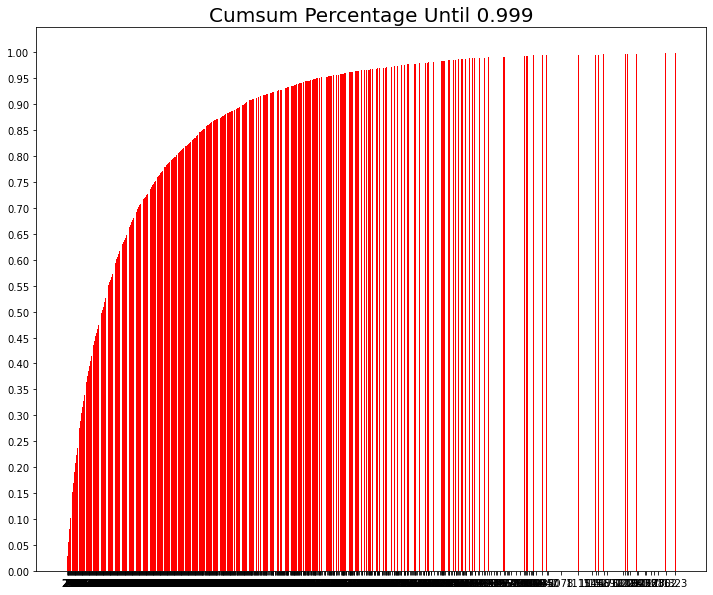

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [25]:
## session Time

In [26]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)
# - 1970 년 1월 1일 부터 경과된 초 단위 시간이 기재되어있다

2000-04-25 23:05:32
2003-02-28 17:49:50


In [27]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [28]:
# cleaning


In [29]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.

def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [30]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


## train,val, test 로 분리하기

In [31]:
data[data['UserId'] == 36].head(), data[data['UserId'] == 36].tail()

(      UserId  ItemId  Rating                Time
 5130      36    2671       5 2000-12-29 03:35:55
 5163      36    2250       4 2000-12-29 03:35:55
 5313      36    2023       4 2000-12-29 03:35:55
 5088      36    1270       5 2000-12-29 03:36:22
 5250      36    3301       4 2000-12-29 03:36:47,
       UserId  ItemId  Rating                Time
 5104      36     247       4 2002-12-22 08:17:48
 5062      36    1266       5 2002-12-22 08:18:29
 5076      36     595       4 2002-12-22 08:18:29
 5126      36    1295       4 2002-12-22 08:18:29
 5180      36    3639       4 2002-12-22 08:18:45)

In [32]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('Time')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['Time'].isin(session_in_train)]
    after_date = data[data['Time'].isin(session_in_test)]
    
    return before_date, after_date

In [33]:
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)
# 180일을 test 로 지정하였고 뒤에 180일을 val 지정

In [34]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [35]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 978534
	 Sessions: 6038
	 Items: 3416
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-05 04:19:56

* valid Set Stats Info
	 Events: 12271
	 Sessions: 399
	 Items: 2606
	 First Time : 2002-03-05 04:21:07
	 Last Time : 2002-09-01 04:20:59

* test Set Stats Info
	 Events: 8806
	 Sessions: 339
	 Items: 2317
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2003-02-28 17:49:50



In [36]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)
print('데이터 준비 끝')

데이터 준비 끝


In [37]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Data pipeline

In [38]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [39]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [40]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 978070, 978193, 978534], dtype=int32)

In [41]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6035, 6036, 6037])

In [42]:
## SessionDataLoader 


In [43]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [44]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [45]:
iter_ex = iter(tr_data_loader)

In [46]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


## Modeling

### Evaluation Metric(MRR)

In [47]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture

In [48]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [49]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [50]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [51]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    520200    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


## Model Training

In [52]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    
    history = {'val_recall':[], 'val_mrr':[], 'train_loss':[], 'Epoch':[]} # 시각화를 위한 history를 생성함
    
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.
        
        history['val_recall'].append(float(val_recall))
        history['val_mrr'].append(float(val_mrr))
        history['train_loss'].append(result[0])
        history['Epoch'].append(epoch)

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")
        
    return history


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [53]:
training = train_model(model, args)

training

print('오래걸린다')

Evaluation:  15%|█▌        | 7/46 [00:10<00:56,  1.44s/it]


	 - Recall@20 epoch 1: 0.057478
	 - MRR@20    epoch 1: 0.014292



Evaluation:  15%|█▌        | 7/46 [00:09<00:52,  1.35s/it]


	 - Recall@20 epoch 2: 0.092634
	 - MRR@20    epoch 2: 0.024780



Evaluation:  15%|█▌        | 7/46 [00:09<00:52,  1.34s/it]

	 - Recall@20 epoch 3: 0.105469
	 - MRR@20    epoch 3: 0.028855

오래걸린다


## Inference

In [57]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:   6%|▌         | 2/33 [00:02<00:39,  1.27s/it]

	 - Recall@20: 0.162109
	 - MRR@20: 0.051778



In [60]:
import seaborn as sns

In [61]:
def draw_graph(training):
    plt.figure(figsize=(12, 12))

    plt.subplot(3, 1, 1)
    sns.lineplot(x=training['Epoch'], y=training['train_loss'], label='train_loss')

    plt.subplot(3, 1, 2)
    sns.lineplot(x=training['Epoch'], y=training['val_recall'], label='val_recall')

    plt.subplot(3, 1, 3)
    sns.lineplot(x=training['Epoch'], y=training['val_mrr'], label='val_mrr')

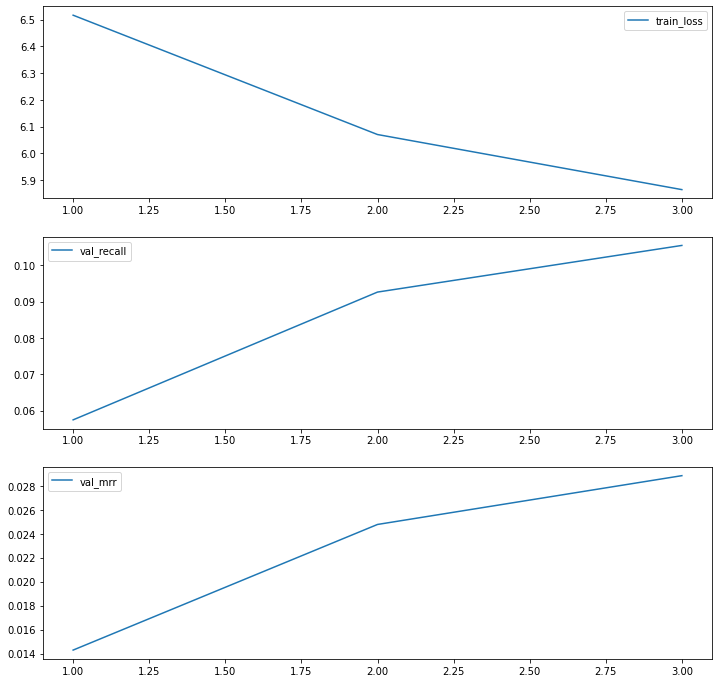

In [62]:
draw_graph(training)

## 모델 개선

### 1) epoch 수 증가시키기
- 3회에서 10회로 증가시켜보았다


In [64]:
args1 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [65]:
model1 = create_model(args1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(256, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    520200    
_________________________________________________________________
dropout_1 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (256, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


In [66]:
training1 = train_model(model1, args1)

Evaluation:  15%|█▌        | 7/46 [00:10<00:56,  1.44s/it]


	 - Recall@20 epoch 1: 0.065848
	 - MRR@20    epoch 1: 0.014257



Evaluation:  15%|█▌        | 7/46 [00:09<00:52,  1.34s/it]


	 - Recall@20 epoch 2: 0.093750
	 - MRR@20    epoch 2: 0.024269



Evaluation:  15%|█▌        | 7/46 [00:09<00:52,  1.35s/it]


	 - Recall@20 epoch 3: 0.107701
	 - MRR@20    epoch 3: 0.030956



Evaluation:  15%|█▌        | 7/46 [00:09<00:51,  1.33s/it]


	 - Recall@20 epoch 4: 0.113839
	 - MRR@20    epoch 4: 0.031248



Evaluation:  15%|█▌        | 7/46 [00:09<00:52,  1.36s/it]


	 - Recall@20 epoch 5: 0.116071
	 - MRR@20    epoch 5: 0.032521



Evaluation:  15%|█▌        | 7/46 [00:09<00:51,  1.32s/it]


	 - Recall@20 epoch 6: 0.113281
	 - MRR@20    epoch 6: 0.033091



Evaluation:  15%|█▌        | 7/46 [00:09<00:53,  1.36s/it]


	 - Recall@20 epoch 7: 0.114397
	 - MRR@20    epoch 7: 0.032146



Evaluation:  15%|█▌        | 7/46 [00:09<00:51,  1.32s/it]


	 - Recall@20 epoch 8: 0.113281
	 - MRR@20    epoch 8: 0.032722



Evaluation:  15%|█▌        | 7/46 [00:09<00:50,  1.31s/it]


	 - Recall@20 epoch 9: 0.111049
	 - MRR@20    epoch 9: 0.031621



Evaluation:  15%|█▌        | 7/46 [00:09<00:52,  1.34s/it]

	 - Recall@20 epoch 10: 0.112723
	 - MRR@20    epoch 10: 0.032237



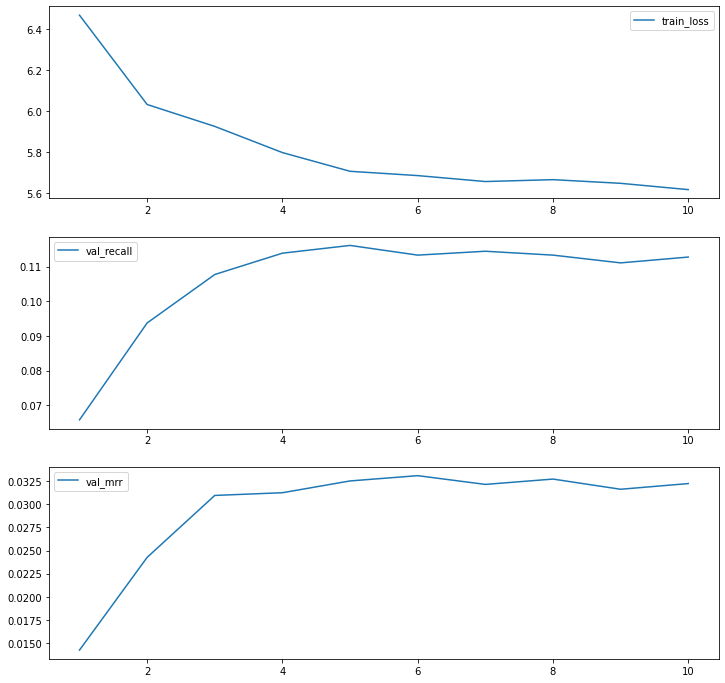

In [67]:
draw_graph(training1)

- train loss 감소
- recall, mrr 증가

### 2) hidden state 증가시키기
- 기존 50에서 100으로 증가시키기

In [68]:
arg2 = Args(tr, val, test, batch_size=256, hsz=100,drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [69]:
model2 = create_model(arg2)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(256, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 100), (256, 100)]  1055400   
_________________________________________________________________
dropout_2 (Dropout)          (256, 100)                0         
_________________________________________________________________
dense_2 (Dense)              (256, 3416)               345016    
Total params: 1,400,416
Trainable params: 1,400,416
Non-trainable params: 0
_________________________________________________________________


In [70]:
training2 = train_model(model2, arg2)

Evaluation:  15%|█▌        | 7/46 [00:09<00:53,  1.36s/it]


	 - Recall@20 epoch 1: 0.084821
	 - MRR@20    epoch 1: 0.023341



Evaluation:  15%|█▌        | 7/46 [00:09<00:52,  1.36s/it]


	 - Recall@20 epoch 2: 0.101004
	 - MRR@20    epoch 2: 0.031316



Evaluation:  15%|█▌        | 7/46 [00:09<00:53,  1.37s/it]


	 - Recall@20 epoch 3: 0.109933
	 - MRR@20    epoch 3: 0.030995



Evaluation:  15%|█▌        | 7/46 [00:09<00:53,  1.37s/it]


	 - Recall@20 epoch 4: 0.108259
	 - MRR@20    epoch 4: 0.031826



Evaluation:  15%|█▌        | 7/46 [00:09<00:52,  1.33s/it]


	 - Recall@20 epoch 5: 0.107143
	 - MRR@20    epoch 5: 0.032099



Evaluation:  15%|█▌        | 7/46 [00:09<00:52,  1.35s/it]


	 - Recall@20 epoch 6: 0.106027
	 - MRR@20    epoch 6: 0.033056



Evaluation:  15%|█▌        | 7/46 [00:09<00:53,  1.36s/it]


	 - Recall@20 epoch 7: 0.107143
	 - MRR@20    epoch 7: 0.032798



Evaluation:  15%|█▌        | 7/46 [00:09<00:52,  1.35s/it]


	 - Recall@20 epoch 8: 0.113281
	 - MRR@20    epoch 8: 0.033250



Evaluation:  15%|█▌        | 7/46 [00:09<00:52,  1.35s/it]


	 - Recall@20 epoch 9: 0.113839
	 - MRR@20    epoch 9: 0.034084



Evaluation:  15%|█▌        | 7/46 [00:09<00:51,  1.33s/it]

	 - Recall@20 epoch 10: 0.112723
	 - MRR@20    epoch 10: 0.033534



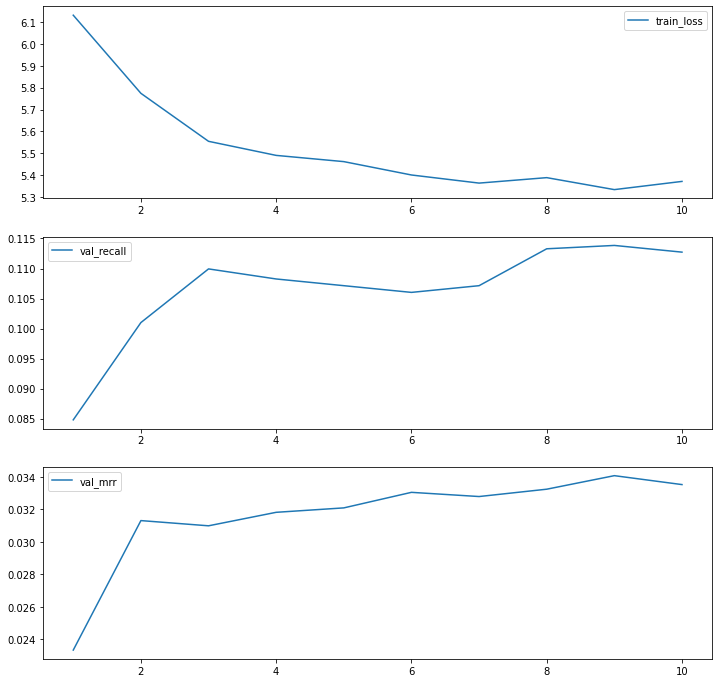

In [71]:
draw_graph(training2)

### 3) hidden state 증가시키기
- 100 에서 150 으로

In [72]:
arg3 = Args(tr, val, test, batch_size=256, hsz=150,drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [73]:
model3 = create_model(arg3)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(256, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 150), (256, 150)]  1605600   
_________________________________________________________________
dropout_3 (Dropout)          (256, 150)                0         
_________________________________________________________________
dense_3 (Dense)              (256, 3416)               515816    
Total params: 2,121,416
Trainable params: 2,121,416
Non-trainable params: 0
_________________________________________________________________


In [74]:
training3 = train_model(model3, arg3)

Evaluation:  15%|█▌        | 7/46 [00:09<00:54,  1.39s/it]


	 - Recall@20 epoch 1: 0.085938
	 - MRR@20    epoch 1: 0.026440



Evaluation:  15%|█▌        | 7/46 [00:09<00:53,  1.37s/it]


	 - Recall@20 epoch 2: 0.101004
	 - MRR@20    epoch 2: 0.030827



Evaluation:  15%|█▌        | 7/46 [00:09<00:53,  1.37s/it]


	 - Recall@20 epoch 3: 0.102121
	 - MRR@20    epoch 3: 0.031996



Evaluation:  15%|█▌        | 7/46 [00:09<00:52,  1.35s/it]


	 - Recall@20 epoch 4: 0.102121
	 - MRR@20    epoch 4: 0.032608



Evaluation:  15%|█▌        | 7/46 [00:09<00:51,  1.32s/it]


	 - Recall@20 epoch 5: 0.104353
	 - MRR@20    epoch 5: 0.031461



Evaluation:  15%|█▌        | 7/46 [00:09<00:52,  1.36s/it]


	 - Recall@20 epoch 6: 0.109933
	 - MRR@20    epoch 6: 0.031644



Evaluation:  15%|█▌        | 7/46 [00:09<00:54,  1.39s/it]


	 - Recall@20 epoch 7: 0.111049
	 - MRR@20    epoch 7: 0.031169



Evaluation:  15%|█▌        | 7/46 [00:09<00:51,  1.33s/it]


	 - Recall@20 epoch 8: 0.111607
	 - MRR@20    epoch 8: 0.032459



Evaluation:  15%|█▌        | 7/46 [00:09<00:51,  1.33s/it]


	 - Recall@20 epoch 9: 0.108259
	 - MRR@20    epoch 9: 0.032009



Evaluation:  15%|█▌        | 7/46 [00:09<00:52,  1.33s/it]

	 - Recall@20 epoch 10: 0.108817
	 - MRR@20    epoch 10: 0.031652



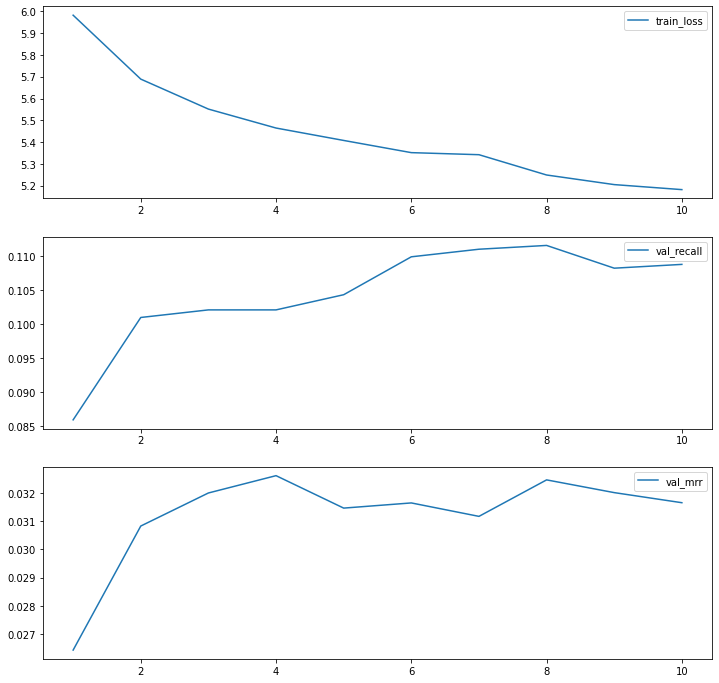

In [75]:
draw_graph(training3)

## 회고


- 다른 노드에 비해선 나는 '추천시스템'분야가 더 어렵게 느껴진다. 그래서 노드의 전체적인 부분을 완벽하게 이해하지 못한 부분이 아쉬웠다. 또 이번노드는 학습 시간이 오래걸려서 정신적으로 지치고 힘든 부분이 있었다.
- 그래도 모델링경우 MRR 이라는 분야를 알게 되어서 새롭고 좋았다.